In [1]:
import kala
import pandas as pd
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [29]:
p = kala.InvestorAgent(is_saver=False, update_from_n_last_games=4)
p.get_trait('is_saver')

False

In [30]:
p.update(payoff=1., did_i_win=False)
p.get_trait('is_saver')

True

constantes:
num_players, num_simulations, num_steps

variables fijas por el momento:
network_structure, sigma

variables:
initial_state, differential_efficient, differential_inefficient, memory, learning_rule

por explorar por persona:
learning_rules con distintas longitudes de memoria
(average, strict, not-strict)

- inicializar constantes
- inicializar juego

- definir variables

- correr juego

visualizar:
- riqueza por grupos (SBM)
- riqueza por tipo de agente
- cambio de porcentaje de agentes c.r. al tiempo



In [2]:
def helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)

    if return_pos:
        pos = nx.spring_layout(g, seed=seed)
        out = (g, pos)
    else:
        out = g

    return out


def helper_two_group_assigment(num_nodes, threshold=0.5, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    if isinstance(threshold, float):
        block1 = rng.random(size=n) < threshold
        block2 = rng.random(size=n + num_nodes % 2) < 1 - threshold
    elif isinstance(threshold, Sequence) and len(threshold) == 2:
        block1 = rng.random(size=n) < threshold[0]
        block2 = rng.random(size=n + num_nodes % 2) < threshold[1]
    else:
        raise TypeError("treshold must be a float or a sequence of two floats")

    return np.hstack((block1, block2))


def _get_broken_down_wealth(game, is_saver):
    return (
        game.get_total_wealth(),
        game.get_total_wealth(filt=is_saver),
        game.get_total_wealth(filt=~is_saver),
    )


def helper_run_simulation(game, is_saver, num_steps):
    game.reset_agents()

    data = [_get_broken_down_wealth(game, is_saver)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_broken_down_wealth(game, is_saver))

    return pd.DataFrame(data, columns=["total", "saver", "non-saver"])

In [3]:
def get_mean_and_std_from(results, cols=["saver", "non-saver"]):
    results_mean = results[
        [col for col in results.columns if "total" in col]
    ].mean(axis=1).to_frame("total")
    results_mean[cols[0]] = results[
        [col for col in results.columns if col.startswith("saver")]
    ].mean(axis=1)
    results_mean[cols[1]] = results[
        [col for col in results.columns if "non-saver" in col]
    ].mean(axis=1)

    results_std = results[
        [col for col in results.columns if "total" in col]
    ].std(axis=1).to_frame("total")
    results_std[cols[0]] = results[
        [col for col in results.columns if col.startswith("saver")]
    ].std(axis=1)
    results_std[cols[1]] = results[
        [col for col in results.columns if "non-saver" in col]
    ].std(axis=1)

    return results_mean, results_std

def plot_std(results_mean, results_std, alpha):
    for col in results_mean.columns:
        plt.fill_between(
            np.arange(len(results_mean)),
            results_mean[col]-results_std[col],
            results_mean[col]+results_std[col],
            alpha=alpha,
            )
    

In [9]:
def play_game(
    num_players,
    saver_thresh,
    differential_efficient,
    differential_inefficient,
    func,
    memory,
    num_steps=50,
    num_simulations=50,
):
    stochastic_strategy = kala.CooperationStrategy(
        stochastic=True,
        rng=0,
        dist_sigma_func=func,
        differential_efficient=differential_efficient,
        differential_inefficient=differential_inefficient,
    )
    g, pos = helper_diagonal_sbm(num_players, p_off=0.1)

    results_mean, results_std = get_mean_std_dfs(
        num_players, saver_thresh, num_steps, num_simulations, g, stochastic_strategy, memory,
    )

    is_saver = helper_two_group_assigment(num_players, threshold=saver_thresh, seed=0)
    plot_network_and_timeseries(results_mean, results_std, is_saver, g, pos)


def get_mean_std_dfs(
    num_players,
    saver_thresh,
    num_steps,
    num_simulations,
    g,
    stochastic_strategy,
    memory=1,
):
    results = pd.DataFrame(index=np.arange(num_steps))
    ### MONTECARLO SIMULATIONS
    for simulation in tqdm(range(num_simulations)):
        is_saver = helper_two_group_assigment(
            num_players, threshold=saver_thresh, seed=simulation
        )

        players = [kala.InvestorAgent(is_saver=s, update_from_n_last_games=memory) for s in is_saver]
        G = kala.SimpleGraph(g, nodes=players)

        game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

        results_dummy = helper_run_simulation(game, is_saver, num_steps=num_steps)
        results = results.join(results_dummy, rsuffix=f"_{simulation}")

    results_mean, results_std = get_mean_and_std_from(results)

    return results_mean, results_std


def plot_network_and_timeseries(means, stds, is_saver, g, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

    ax = axs[0]
    nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
    ax.set_title(rf"$\tau = {saver_thresh}$")

    ax = axs[1]
    means.plot(ax=ax)
    plot_std(means, stds, alpha=0.3)
    plt.grid()

100%|██████████| 50/50 [00:01<00:00, 36.97it/s]


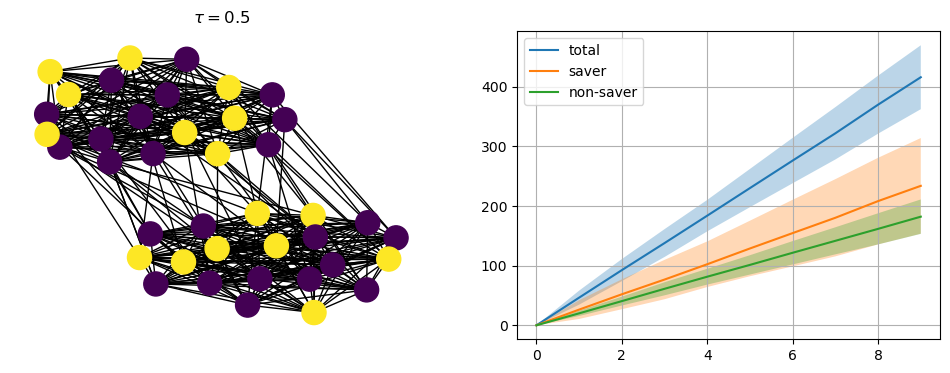

In [21]:
### INPUTS
saver_thresh = 0.5
num_players = 40

differential_efficient = 1e-10
differential_inefficient = 0.999

func = lambda x: 1e-10

memory = 10

play_game(num_players, saver_thresh, differential_efficient, differential_inefficient, func, memory)

100%|██████████| 50/50 [00:00<00:00, 1360.89it/s]


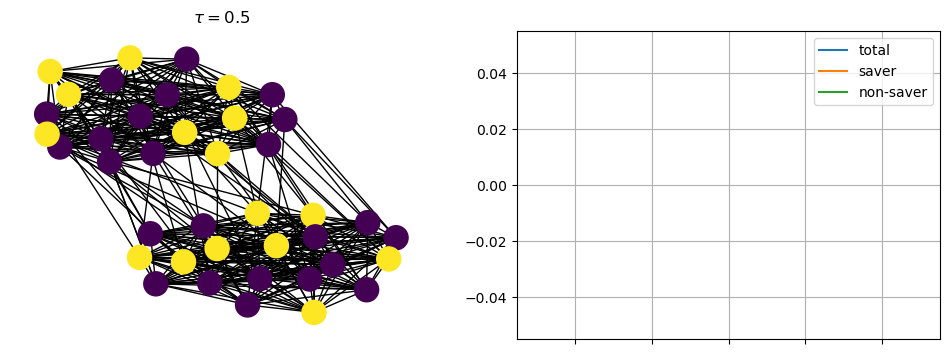

In [15]:
### INPUTS
saver_thresh = 0.5
num_players = 40

differential_efficient = 1e-10
differential_inefficient = 0.999

func = lambda x: 1e-10

memory = 0


play_game(num_players, saver_thresh, differential_efficient, differential_inefficient, func, memory)

100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


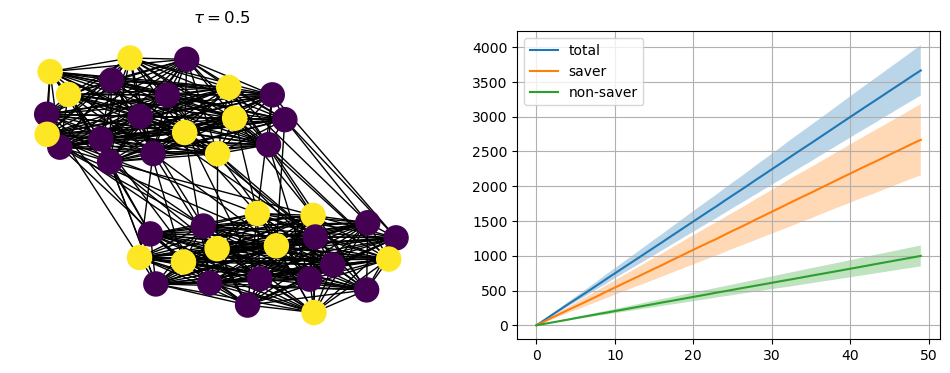

In [8]:
differential_efficient = 0.25
differential_inefficient = 0.2

play_game(num_players, saver_thresh, differential_efficient, differential_inefficient, func)

TODO:

- evolutionary game
- updating rule
- memory (decaying memory, random memory)
- spatial dependence 